In [173]:
#constants

DATA_PATH = 'C:\\Users\\gt\\End to End Data Science Project\\Processed data\\preprocessed_data.pkl'
EXPORT_FEATURES_DIR = "C:\\Users\\gt\\End to End Data Science Project\\Processed data"

FIG_DIR = "C:\\Users\\gt\\End to End Data Science Project\\Reports"
TRANSPARENT_STRING = 'rgba(0, 0, 0, 0)'
NA_string='Not Specified'
ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageHaveWorkedWith',
             'DatabaseHaveWorkedWith',
             'PlatformHaveWorkedWith',
             'WebframeHaveWorkedWith', 
             'MiscTechHaveWorkedWith', 
             'ToolsTechHaveWorkedWith', 
             'NEWCollabToolsHaveWorkedWith']

In [174]:
#Load pachages
import pandas as pd
import numpy as np
import logging
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


import plotly.express as px
import os
import yaml
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Read data and preprocess data


<br>

In [175]:
processed_df = pd.read_pickle(DATA_PATH)

In [176]:
#Onehot encode
df=processed_df.copy()
encoded_dfs={}
for col in ROLE_COLS+TECH_COLS:
    Binarizer = MultiLabelBinarizer()
    encoded_df=pd.DataFrame(Binarizer.fit_transform(df[col]),
                            columns=Binarizer.classes_,
                           index=df[col].index)

    encoded_dfs[col]=encoded_df
df = pd.concat(encoded_dfs, axis=1)    
df.head()

DevType                           \
  Academic researcher Data or business analyst   
0                   0                        0   
1                   0                        0   
2                   0                        0   
3                   0                        0   
4                   0                        0   

                                                                        \
  Data scientist or machine learning specialist Database administrator   
0                                             0                      0   
1                                             0                      0   
2                                             0                      0   
3                                             0                      0   
4                                             0                      0   

                                                                        \
  Designer DevOps specialist Developer, QA or test Developer, back-end   
0        0                 0                     0                   0   
1        0                 0                     0                   0   
2        0                 0                     0                   0   
3        0                 0                     0                   0   
4        0                 0                     0                   0   

                                                 \
  Developer, desktop or enterprise applications   
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             1   

                                               ...  \
  Developer, embedded applications or devices  ...   
0                                           0  ...   
1                                           0  ...   
2                                           0  ...   
3                                           0  ...   
4                                           0  ...   

  NEWCollabToolsHaveWorkedWith                                           \
                       RStudio Rider RubyMine Sublime Text TextMate Vim   
0                            0     0        0            0        0   0   
1                            0     0        0            0        0   0   
2                            1     0        0            1        0   0   
3                            0     0        0            0        0   0   
4                            0     0        0            0        0   1   

                                                   
  Visual Studio Visual Studio Code Webstorm Xcode  
0             0                  0        0     1  
1             0                  0        0     0  
2             0                  1        0     0  
3             0                  0        0     0  
4             0                  0        0     0  

[5 rows x 150 columns]

<br>

## Dimensionality reduction

t-SNE a non-linear dimensionality reduction algorithm finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features. But it is not a clustering algorithm it is a dimensionality reduction algorithm. This is because it maps the multi-dimensional data to a lower dimensional space, the input features are no longer identifiable. Thus you cannot make any inference based only on the output of t-SNE. So essentially it is mainly a data exploration and visualization technique.

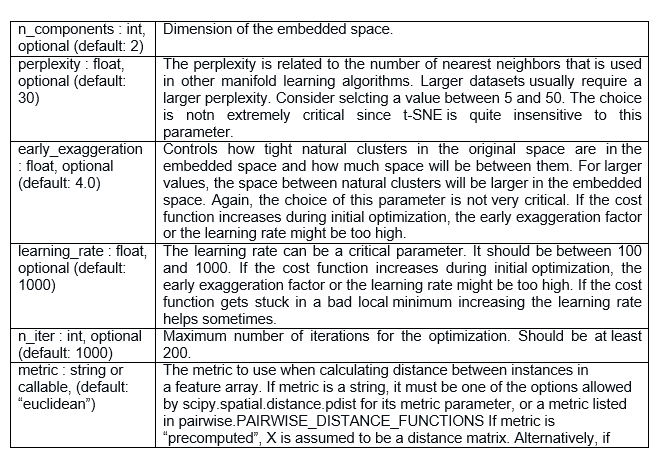

<br>

In [177]:
#prepare sub dataframe
skills=df.drop('DevType', axis=1).copy()
std_skills=StandardScaler().fit_transform(skills)

In [178]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

In [179]:
tsne_projection = pd.DataFrame(tsne_projection, index=skills.columns)
tsne_projection.shape

(125, 2)

In [180]:
fig=px.scatter(x=tsne_projection[0], y=tsne_projection[1], text = tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()
fig.write_html(os.path.join(FIG_DIR, 'TSNE_Scatter.html'))

<br>

## Clustering

a= intracluster distance

b=intercluster distance

Silhouette coefficient= b-a/max(b,a)

If our clustering is good then we have small intracluster distance then the Silhouette coefficient value is positive

If our clustering is bad then we have large intracluster distance then the Silhouette coefficient value is negative

Silhouette coefficient lies in between -1 and 1

If the value moves towards 1 then clustering is good

If the value moves towards <0 then clustering is bad

<br>

In [181]:
range_n_cluster = list(range(10,25))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)

    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

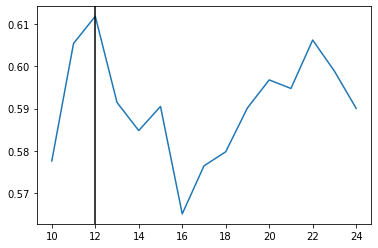

In [182]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [183]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]

In [184]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

fig.write_html(os.path.join(FIG_DIR, 'Clustering_Scatter.html'))

In [185]:
tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

skills_group_0     [Assembly, C, C++, Julia, Matlab, Python, R, D...
skills_group_1     [Go, DynamoDB, PostgreSQL, AWS, Svelte, Ansibl...
skills_group_10            [Ruby, Ruby on Rails, RubyMine, TextMate]
skills_group_11    [APL, COBOL, Crystal, Delphi, IBM DB2, IBM Clo...
skills_group_2     [HTML/CSS, JavaScript, Node.js, TypeScript, Mo...
skills_group_3     [C#, F#, PowerShell, VBA, Microsoft SQL Server...
skills_group_4       [Clojure, Elixir, Erlang, Haskell, LISP, Emacs]
skills_group_5     [Groovy, Java, Oracle, Oracle Cloud Infrastruc...
skills_group_6     [Dart, Kotlin, Objective-C, Swift, Firebase, S...
skills_group_7                 [Bash/Shell, Perl, Rust, Neovim, Vim]
skills_group_8     [PHP, SQL, MariaDB, MySQL, Drupal, Laravel, Sy...
skills_group_9     [Scala, Cassandra, Couchbase, Elasticsearch, R...
dtype: object

In [186]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

In [187]:
for cluster, skills_ in skills_clusters.items():
    print(cluster)
    print(skills_)

skills_group_0
['Assembly', 'C', 'C++', 'Julia', 'Matlab', 'Python', 'R', 'Django', 'FastAPI', 'Flask', 'Keras', 'NumPy', 'Pandas', 'Qt', 'TensorFlow', 'Torch/PyTorch', 'IPython/Jupyter', 'PyCharm', 'RStudio']
skills_group_1
['Go', 'DynamoDB', 'PostgreSQL', 'AWS', 'Svelte', 'Ansible', 'Chef', 'Deno', 'Docker', 'Flow', 'Git', 'Kubernetes', 'Pulumi', 'Puppet', 'Terraform']
skills_group_10
['Ruby', 'Ruby on Rails', 'RubyMine', 'TextMate']
skills_group_11
['APL', 'COBOL', 'Crystal', 'Delphi', 'IBM DB2', 'IBM Cloud or Watson']
skills_group_2
['HTML/CSS', 'JavaScript', 'Node.js', 'TypeScript', 'MongoDB', 'Heroku', 'Angular', 'Angular.js', 'Express', 'Gatsby', 'React.js', 'jQuery', 'Cordova', 'React Native', 'Yarn', 'Visual Studio Code']
skills_group_3
['C#', 'F#', 'PowerShell', 'VBA', 'Microsoft SQL Server', 'Microsoft Azure', 'ASP.NET', 'ASP.NET Core ', '.NET Core / .NET 5', '.NET Framework', 'Unity 3D', 'Unreal Engine', 'Xamarin', 'Notepad++', 'Rider', 'Visual Studio']
skills_group_4
['Clo

In [188]:
new_features = []

for cluster, skills_ in skills_clusters.items():
    cluster_sum = skills.dropl evel(0, axis=1)[skills_].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

SyntaxError: invalid syntax (<ipython-input-188-2925e30f5e67>, line 4)

In [ ]:
fe_clustered_skills

In [ ]:
features_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path)

In [ ]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)

In [ ]:
description_path